In [2]:
import os
import shutil
import json
from tqdm import tqdm

# Paths
coco_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\train'
output_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset'

# Load annotations
with open(os.path.join(coco_path, 'labels.json')) as f:
    annotations = json.load(f)

# Create class directories
categories = {cat['id']: cat['name'] for cat in annotations['categories']}
for cat in categories.values():
    os.makedirs(os.path.join(output_path, 'train', cat), exist_ok=True)

# Move images to class directories
for ann in tqdm(annotations['annotations']):
    img_id = ann['image_id']
    cat_id = ann['category_id']
    img_name = f'{img_id:012d}.jpg'
    src_path = os.path.join(coco_path, 'data', img_name)
    dst_path = os.path.join(output_path, 'train', categories[cat_id], img_name)
    shutil.copy(src_path, dst_path)

print("COCO-2017 dataset has been successfully converted to TensorFlow ImageFolder dataset.")


100%|██████████| 860001/860001 [25:18<00:00, 566.39it/s]  

COCO-2017 dataset has been successfully converted to TensorFlow ImageFolder dataset.


In [3]:
import os
import shutil
import json
import random
from tqdm import tqdm

# Paths
coco_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\train'
output_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset'

# Load annotations
with open(os.path.join(coco_path, 'labels.json')) as f:
    annotations = json.load(f)

# Create class directories for train, validation, and test
categories = {cat['id']: cat['name'] for cat in annotations['categories']}
for split in ['train', 'validation', 'test']:
    for cat in categories.values():
        os.makedirs(os.path.join(output_path, split, cat), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Shuffle and split the annotations
random.shuffle(annotations['annotations'])
total_annotations = len(annotations['annotations'])
train_end = int(train_ratio * total_annotations)
val_end = int((train_ratio + val_ratio) * total_annotations)

train_annotations = annotations['annotations'][:train_end]
val_annotations = annotations['annotations'][train_end:val_end]
test_annotations = annotations['annotations'][val_end:]

# Function to move images to the respective directories
def move_images(annotations, split):
    for ann in tqdm(annotations, desc=f'Moving {split} images'):
        img_id = ann['image_id']
        cat_id = ann['category_id']
        img_name = f'{img_id:012d}.jpg'
        src_path = os.path.join(coco_path, 'data', img_name)
        dst_path = os.path.join(output_path, split, categories[cat_id], img_name)
        shutil.copy(src_path, dst_path)

# Move images to the respective directories
move_images(train_annotations, 'train')
move_images(val_annotations, 'validation')
move_images(test_annotations, 'test')

print("COCO-2017 dataset has been successfully split into train, validation, and test sets.")


Moving test images: 100%|██████████| 129001/129001 [06:06<00:00, 351.79it/s]

COCO-2017 dataset has been successfully split into train, validation, and test sets.


Person only

In [1]:
import os
import shutil
import json
import random
import logging
from tqdm import tqdm

# Paths
coco_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\train'
output_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset'

# Setup logging
logging.basicConfig(filename='dataset_conversion.log', level=logging.INFO)

# Load annotations
with open(os.path.join(coco_path, 'labels.json')) as f:
    annotations = json.load(f)

# Filter annotations for 'person' class
person_id = next(cat['id'] for cat in annotations['categories'] if cat['name'] == 'person')
person_annotations = [ann for ann in annotations['annotations'] if ann['category_id'] == person_id]

# Create directories for train, validation, and test
for split in ['train_person', 'validation_person', 'test_person']:
    os.makedirs(os.path.join(output_path, split, 'person'), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Shuffle and split the annotations
random.shuffle(person_annotations)
total_annotations = len(person_annotations)
train_end = int(train_ratio * total_annotations)
val_end = int((train_ratio + val_ratio) * total_annotations)

train_annotations = person_annotations[:train_end]
val_annotations = person_annotations[train_end:val_end]
test_annotations = person_annotations[val_end:]

# Function to move images to the respective directories
def move_images(annotations, split):
    for ann in tqdm(annotations, desc=f'Moving {split} images'):
        img_id = ann['image_id']
        img_name = f'{img_id:012d}.jpg'
        src_path = os.path.join(coco_path, 'data', img_name)
        dst_path = os.path.join(output_path, split, 'person', img_name)
        
        try:
            shutil.copy(src_path, dst_path)
        except FileNotFoundError:
            logging.warning(f"File {img_name} not found. Skipping.")
        except Exception as e:
            logging.error(f"Error copying {img_name}: {e}")

# Move images to the respective directories
move_images(train_annotations, 'train_person')
move_images(val_annotations, 'validation_person')
move_images(test_annotations, 'test_person')

print("COCO-2017 dataset has been successfully split into train, validation, and test sets for the 'person' class.")


Moving test_person images: 100%|██████████| 39370/39370 [01:37<00:00, 402.82it/s]

COCO-2017 dataset has been successfully split into train, validation, and test sets for the 'person' class.


person plus negative

In [8]:
import os
import shutil
import json
import random
from tqdm import tqdm

# Paths
coco_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\train'
output_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset'

# Load annotations
with open(os.path.join(coco_path, 'labels.json')) as f:
    annotations = json.load(f)

# Create directories
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(output_path, split), exist_ok=True)
    os.makedirs(os.path.join(output_path, f'{split}_person', 'person'), exist_ok=True)
    os.makedirs(os.path.join(output_path, f'{split}_person', 'negative'), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Shuffle and split the annotations
random.shuffle(annotations['annotations'])
total_annotations = len(annotations['annotations'])
train_end = int(train_ratio * total_annotations)
val_end = int((train_ratio + val_ratio) * total_annotations)

train_annotations = annotations['annotations'][:train_end]
val_annotations = annotations['annotations'][train_end:val_end]
test_annotations = annotations['annotations'][val_end:]

# Function to move images
def move_images(annotations, split):
    person_images = set()
    all_images = set()

    for ann in tqdm(annotations, desc=f'Moving {split} images'):
        img_id = ann['image_id']
        cat_id = ann['category_id']
        img_name = f'{img_id:012d}.jpg'
        src_path = os.path.join(coco_path, 'data', img_name)
        
        all_images.add(img_name)
        if cat_id == 1:  # Assuming 'person' class has ID 1
            person_images.add(img_name)
            dst_path = os.path.join(output_path, f'{split}_person', 'person', img_name)
        else:
            dst_path = os.path.join(output_path, f'{split}_person', 'negative', img_name)
        
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: {src_path} does not exist and will be skipped.")

    # Move negative samples
    for img_name in all_images - person_images:
        src_path = os.path.join(coco_path, 'data', img_name)
        dst_path = os.path.join(output_path, f'{split}_person', 'negative', img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: {src_path} does not exist and will be skipped.")

# Move images for each split
move_images(train_annotations, 'train')
move_images(val_annotations, 'validation')
move_images(test_annotations, 'test')

print("Dataset has been successfully split and filtered.")


Moving test images: 100%|██████████| 129001/129001 [05:22<00:00, 400.03it/s]


Dataset has been successfully split and filtered.


Data Visualize


Training Set - Person


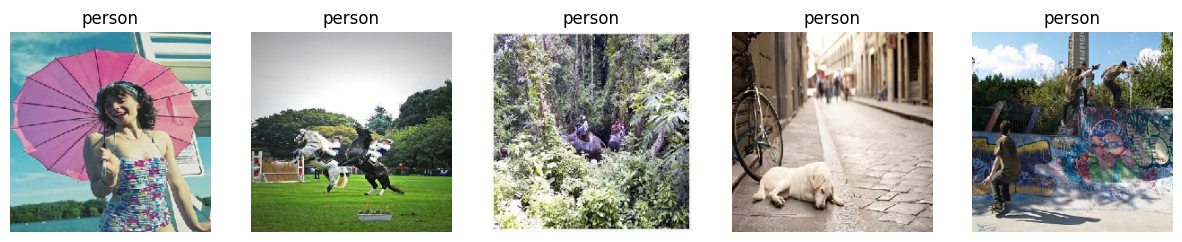

Training Set - Negative


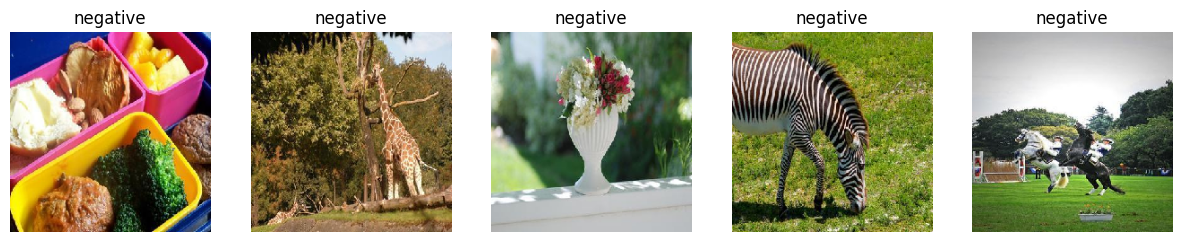

Class Distribution - Training Set


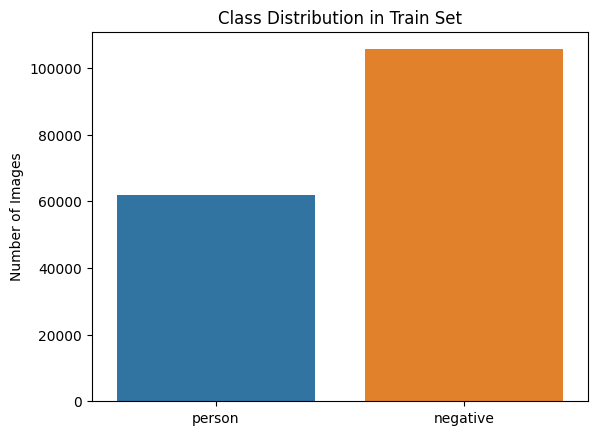

Class Distribution - Validation Set


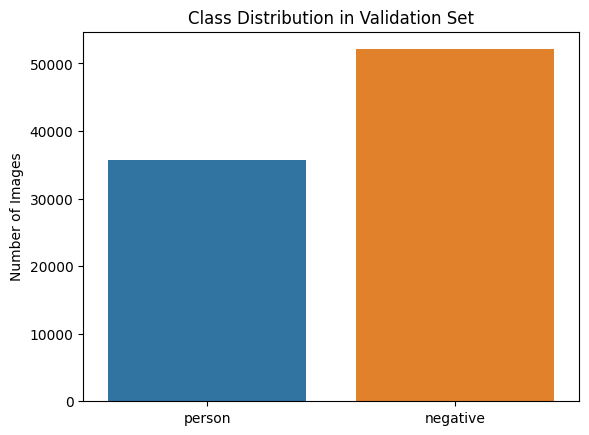

Class Distribution - Test Set


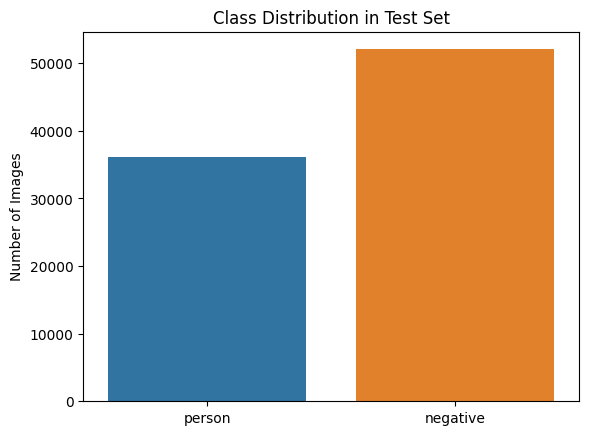

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the output path
output_path = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset'

# Function to plot sample images
def plot_sample_images(directory, class_name, num_images=5):
    class_dir = os.path.join(directory, class_name)
    images = os.listdir(class_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot sample images from each class in the training set
print("Training Set - Person")
plot_sample_images(os.path.join(output_path, 'train_person'), 'person')
print("Training Set - Negative")
plot_sample_images(os.path.join(output_path, 'train_person'), 'negative')

# Function to plot class distribution
def plot_class_distribution(directory, split_name):
    person_count = len(os.listdir(os.path.join(directory, f'{split_name}_person', 'person')))
    negative_count = len(os.listdir(os.path.join(directory, f'{split_name}_person', 'negative')))
    
    sns.barplot(x=['person', 'negative'], y=[person_count, negative_count])
    plt.title(f'Class Distribution in {split_name.capitalize()} Set')
    plt.ylabel('Number of Images')
    plt.show()

# Plot class distribution for each split
print("Class Distribution - Training Set")
plot_class_distribution(output_path, 'train')
print("Class Distribution - Validation Set")
plot_class_distribution(output_path, 'validation')
print("Class Distribution - Test Set")
plot_class_distribution(output_path, 'test')


Model training with 80 classes

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Paths
train_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\train'
val_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\validation'
test_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\test'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


Found 342996 images belonging to 80 classes.
Found 95879 images belonging to 80 classes.
Found 95894 images belonging to 80 classes.
Epoch 1/10
10719/10719 ━━━━━━━━━━━━━━━━━━━━ 4586s 427ms/step - accuracy: 0.2625 - loss: 2.6706 - val_accuracy: 0.3151 - val_loss: 2.3428
Epoch 2/10
10719/10719 ━━━━━━━━━━━━━━━━━━━━ 4029s 376ms/step - accuracy: 0.2814 - loss: 2.4755 - val_accuracy: 0.3331 - val_loss: 2.2944
Epoch 3/10
10719/10719 ━━━━━━━━━━━━━━━━━━━━ 3946s 368ms/step - accuracy: 0.2854 - loss: 2.4425 - val_accuracy: 0.3210 - val_loss: 2.2690
Epoch 4/10
10719/10719 ━━━━━━━━━━━━━━━━━━━━ 4532s 423ms/step - accuracy: 0.2863 - loss: 2.4228 - val_accuracy: 0.3270 - val_loss: 2.2444
Epoch 5/10
10719/10719 ━━━━━━━━━━━━━━━━━━━━ 4054s 378ms/step - accuracy: 0.2861 - loss: 2.4039 - val_accuracy: 0.3289 - val_loss: 2.2410
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 1246s 416ms/step - accuracy: 0.3328 - loss: 2.2903
Test Loss: 2.2829558849334717
Test Accuracy: 0.3355267345905304
2997/2997 ━━━━━━━━━━━━━━━━━━━━ 887s 

c:\Users\xxnab\OneDrive\Documents\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xxnab\OneDrive\Documents\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\xxnab\OneDrive\Documents\GitHub\FYP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Model training for person only

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Paths
train_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\train_person'
val_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\validation_person'
test_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\test_person'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='softmax')(x)  # Only one class: 'person'

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


Found 55593 images belonging to 1 classes.
Found 25050 images belonging to 1 classes.
Found 25304 images belonging to 1 classes.
Epoch 1/10


c:\Users\xxnab\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\xxnab\anaconda3\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
c:\Users\xxnab\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will b

1738/1738 ━━━━━━━━━━━━━━━━━━━━ 838s 479ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 832s 478ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 804s 462ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
1738/1738 ━━━━━━━━━━━━━━━━━━━━ 807s 464ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
791/791 ━━━━━━━━━━━━━━━━━━━━ 254s 321ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0


c:\Users\xxnab\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


791/791 ━━━━━━━━━━━━━━━━━━━━ 251s 316ms/step
Classification Report
              precision    recall  f1-score   support

      person       1.00      1.00      1.00     25304

    accuracy                           1.00     25304
   macro avg       1.00      1.00      1.00     25304
weighted avg       1.00      1.00      1.00     25304

Confusion Matrix
[[25304]]


c:\Users\xxnab\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [9]:
# Save the model
model.save(r'C:\\Users\\xxnab\\OneDrive\\Documents\\GitHub\\FYP\\model\\model_person_only.keras')


Model training with person and negative samples

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Paths
train_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\train_person'
val_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\validation_person'
test_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\test_person'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['negative', 'person']))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


Found 167386 images belonging to 2 classes.
Found 87825 images belonging to 2 classes.
Found 88267 images belonging to 2 classes.
Epoch 1/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 3469s 662ms/step - accuracy: 0.6351 - loss: 0.6056 - val_accuracy: 0.6506 - val_loss: 0.5833
Epoch 2/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2577s 492ms/step - accuracy: 0.6444 - loss: 0.5766 - val_accuracy: 0.6556 - val_loss: 0.5820
Epoch 3/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2584s 494ms/step - accuracy: 0.6434 - loss: 0.5742 - val_accuracy: 0.6510 - val_loss: 0.5838
Epoch 4/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2596s 496ms/step - accuracy: 0.6426 - loss: 0.5700 - val_accuracy: 0.6615 - val_loss: 0.5728
Epoch 5/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2600s 497ms/step - accuracy: 0.6440 - loss: 0.5674 - val_accuracy: 0.6497 - val_loss: 0.5748
Epoch 6/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2549s 487ms/step - accuracy: 0.6451 - loss: 0.5643 - val_accuracy: 0.6546 - val_loss: 0.5793
Epoch 7/10
5231/5231 ━━━━━━━━━━━━━━━━━━━━ 2564s 490ms/step -

In [11]:
# Save the model
model.save(r'C:\\Users\\xxnab\\OneDrive\\Documents\\GitHub\\FYP\\model\\model_person_negative_only.keras')


Reduce Input size

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Paths
train_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\train_person'
val_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\validation_person'
test_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\test_person'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),  # Reduced from 224x224
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['negative', 'person']))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


Found 167386 images belonging to 2 classes.
Found 87825 images belonging to 2 classes.
Found 88267 images belonging to 2 classes.
Epoch 1/10
5231/5231 [==============================] - 1085s 207ms/step - loss: 0.5991 - accuracy: 0.6341 - val_loss: 0.5954 - val_accuracy: 0.6358
Epoch 2/10
5231/5231 [==============================] - 1031s 197ms/step - loss: 0.5889 - accuracy: 0.6373 - val_loss: 0.5915 - val_accuracy: 0.6149
Epoch 3/10
5231/5231 [==============================] - 950s 182ms/step - loss: 0.5843 - accuracy: 0.6389 - val_loss: 0.5869 - val_accuracy: 0.6502
Epoch 4/10
5231/5231 [==============================] - 945s 181ms/step - loss: 0.5808 - accuracy: 0.6393 - val_loss: 0.5861 - val_accuracy: 0.6481
Epoch 5/10
5231/5231 [==============================] - 963s 184ms/step - loss: 0.5777 - accuracy: 0.6392 - val_loss: 0.5858 - val_accuracy: 0.6459
Epoch 6/10
2759/2759 [==============================] - 326s 118ms/step - loss: 0.5883 - accuracy: 0.6485
Test Loss: 0.588277280

In [2]:
# Save the model
model.save(r'C:\\Users\\xxnab\\OneDrive\\Documents\\GitHub\\FYP\\model\\model_reduce_input_size.keras')

Add layers to the model

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Paths
train_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\train_person'
val_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\validation_person'
test_dir = r'C:\\Users\\xxnab\\fiftyone\\coco-2017\\tensorflow_dataset\\test_person'

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers[-20:]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['negative', 'person']))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


Found 167386 images belonging to 2 classes.
Found 87825 images belonging to 2 classes.
Found 88267 images belonging to 2 classes.
Epoch 1/50
5231/5231 [==============================] - 7865s 2s/step - loss: 0.8697 - accuracy: 0.5792 - val_loss: 0.6303 - val_accuracy: 0.6250
Epoch 2/50
5231/5231 [==============================] - 7847s 2s/step - loss: 0.7694 - accuracy: 0.6036 - val_loss: 0.6256 - val_accuracy: 0.6174
Epoch 3/50
4022/5231 [======================>.......] - ETA: 27:21 - loss: 0.7247 - accuracy: 0.6131

: 